In [28]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import matplotlib.pyplot as plt

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [17]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/195733
Connected. Call `.close()` to terminate connection gracefully.


In [18]:
weather_fg = fs.get_feature_group(name="weather", version=3)
query = weather_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="weather",
                                             version=3,
                                             description="Read from Weather",
                                             query=query)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/195733/fs/195652/fv/weather/version/3


In [25]:
# set up dates
train_start = "1996-02-01 22:00:00"
train_end = "2020-02-01 22:00:00"
test_start = "2020-02-01 22:00:00"
test_end = "2024-01-03 08:00:00"

# create a train-test split dataset
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end
)

Finished: Reading data from Hopsworks, using ArrowFlight (4.04s) 


In [26]:
print(X_train.columns)
print(X_test.columns)
# print(y_train.info())
# print(y_test.info())
X_train = X_train.set_index("date_time")
X_test = X_test.set_index("date_time")
X_train = X_train.asfreq('h')
X_test = X_test.asfreq('h')
print(X_train.columns)
print(X_test.columns)

Index(['date_time', 'lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur', 'id'],
      dtype='object')
Index(['date_time', 'lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur', 'id'],
      dtype='object')
Index(['lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur', 'id'],
      dtype='object')
Index(['lufttemperatur', 'vindriktning', 'vindhastighet',
       'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind',
       'max_av_medelvindhastighet', 'daggpunktstemperatur', 'id'],
      dtype='object')


In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210384 entries, 1996-02-01 22:00:00+00:00 to 2020-02-01 21:00:00+00:00
Freq: H
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   lufttemperatur             210384 non-null  float64            
 1   vindriktning               210384 non-null  float64            
 2   vindhastighet              210384 non-null  float64            
 3   relativ_luftfuktighet      210384 non-null  float64            
 4   nederbrdsmngd              210384 non-null  float64            
 5   sikt                       210384 non-null  float64            
 6   byvind                     210384 non-null  float64            
 7   max_av_medelvindhastighet  210384 non-null  float64            
 8   daggpunktstemperatur       210384 non-null  float64            
 9   id                         210384 non-null  datetime64[us, UTC]
dtypes:

In [23]:
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 6
             )

forecaster.fit(y=X_train["lufttemperatur"], exog=X_train.drop(columns=["lufttemperatur", "id"]))
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['vindriktning', 'vindhastighet', 'relativ_luftfuktighet', 'nederbrdsmngd', 'sikt', 'byvind', 'max_av_medelvindhastighet', 'daggpunktstemperatur'] 
Training range: [Timestamp('1996-02-01 22:00:00+0000', tz='UTC'), Timestamp('2020-02-01 21:00:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_s

In [27]:
predictions = forecaster.predict(steps=len(X_test["lufttemperatur"]), exog=X_test.drop(columns=["lufttemperatur", "id"]))
error_mse = mean_squared_error(
                y_true = X_test["lufttemperatur"],
                y_pred = predictions
            )

print(f"Test error (MSE): {error_mse}")

Test error (MSE): 2.2474700616655485


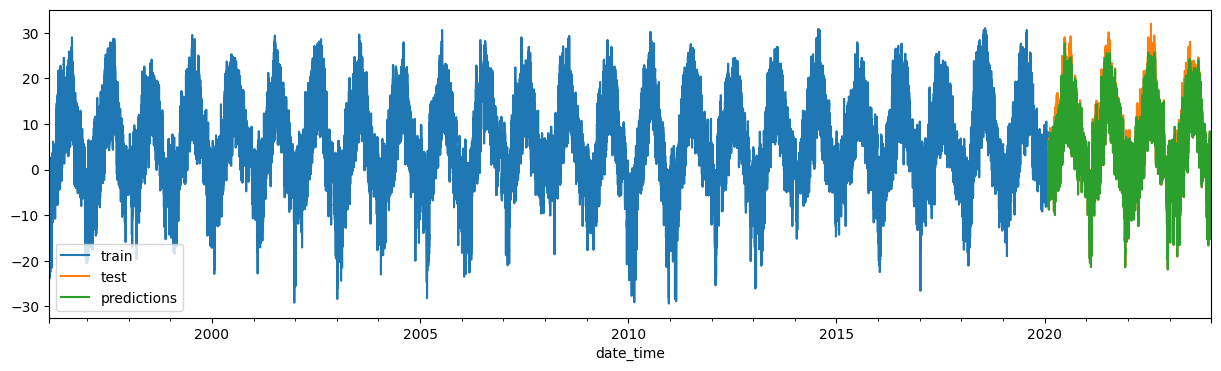

In [34]:
fig, ax = plt.subplots(figsize=(15, 4))
X_train['lufttemperatur'].plot(ax=ax, label='train')
X_test['lufttemperatur'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

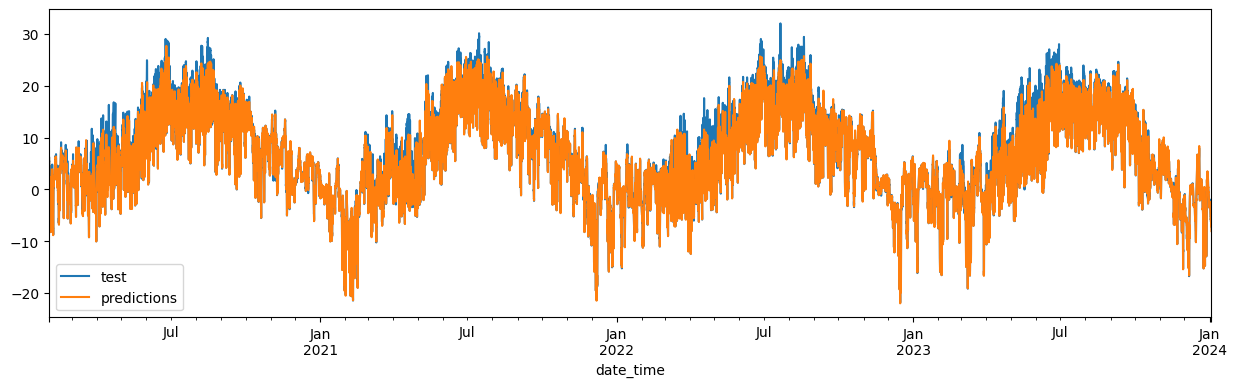

In [33]:
fig, ax = plt.subplots(figsize=(15, 4))
X_test['lufttemperatur'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
mr = project.get_model_registry()

model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"mse" : mse},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


Model export complete: 100%|██████████| 6/6 [00:15<00:00,  2.52s/it]                   

Model created, explore it at https://c.app.hopsworks.ai:443/p/195733/models/wine_model/2


Model(name: 'wine_model', version: 2)